In [26]:
import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
np.random.seed(12345)

#####################################
###### INITIALISING PARAMETERS ######
#####################################

# def a0(x):
#     return 2 + math.sin(2*math.pi *x)

# def a0(x):
#     if 0 <= x < xd:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

import numpy as np

def a0(x, beta):
    """
    Computes the coefficient a0 at points x using the parameter beta.
    
    Parameters:
        x (array-like): Spatial coordinates.
        beta (tuple): (x_star, r) where x_star is the center of the interval 
                      and r is the half-width of the interval.
    
    Returns:
        np.array: Coefficient values; 2 if x is inside the interval, 1 otherwise.
    """
    x_star, r = beta
    x = np.asarray(x)
    return np.where((x >= (x_star - r)) & (x <= (x_star + r)), 2.0, 1.0)


# def f(x, beta):
#     x = np.asarray(x)
#     return a0(x, beta) * np.pi**2 * np.sin(np.pi * x)
def f(x, beta):
    x = np.asarray(x)
    return np.ones_like(x)

n2 =5

####################################
######### HELPER FUNCTIONS #########
####################################

    
# helper functions
def GL(x_left, x_right, func):
    # Ensure xi and ci are NumPy arrays:
    xi, ci = np.polynomial.legendre.leggauss(n2)
    # Map the nodes from [-1,1] to [x_left, x_right]
    x_mapped = 0.5 * ((x_right - x_left) * xi + (x_right + x_left))
    # Evaluate the integrand at all mapped nodes (func must be vectorized or accept an array)
    integrand_values = func(x_mapped)
    # Compute the weighted sum using a dot-product and return the scaled result.
    return 0.5 * (x_right - x_left) * np.dot(ci, integrand_values)

def piecewise_GL(integrand, x_left, x_right, discont_points=None):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre quadrature,
    splitting the integration at any discontinuity points provided in discont_points.
    
    Parameters:
      integrand      : function to integrate, which must accept a NumPy array.
      x_left, x_right: the endpoints of the integration interval.
      n2             : number of Gauss–Legendre quadrature points.
      discont_points : a list (or scalar) of discontinuity points in (x_left, x_right).
                       If None or empty, no splitting is performed.
    
    Returns:
      The value of the integral.
    """
    # If no discontinuity is provided, do a single integration.
    if discont_points is None or len(discont_points) == 0:
        return GL(x_left=x_left, x_right=x_right, func=integrand)
    
    # Ensure discont_points is a list; if it's a scalar, convert it.
    if not isinstance(discont_points, (list, tuple, np.ndarray)):
        discont_points = [discont_points]
    
    # Filter out those discontinuity points that lie within (x_left, x_right)
    splits = [p for p in discont_points if x_left < p < x_right]
    
    # Build the list of subinterval endpoints
    pts = [x_left] + sorted(splits) + [x_right]
    
    # Integrate over each subinterval and sum the results.
    total = 0.0
    for i in range(len(pts) - 1):
        total += GL(x_left=pts[i], x_right=pts[i+1], func=integrand)
    return total

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0
def phi_i(i, x, mesh):
    """
    Standard 1D hat (finite element) function.
    This returns the value of the i-th hat function at x, given a mesh.
    """
    x = np.asarray(x)  # Ensure x is a NumPy array.
    N = len(mesh) - 1  # Number of elements; nodes are 0,1,...,N.
    
    if i == 0:
        # For the left boundary, phi_0 is nonzero on [mesh[0], mesh[1]]
        cond = (x >= mesh[0]) & (x <= mesh[1])
        return np.where(cond, (mesh[1] - x) / (mesh[1] - mesh[0]), 0.0)
    
    elif i == N:
        # For the right boundary, phi_N is nonzero on [mesh[N-1], mesh[N]]
        cond = (x >= mesh[N-1]) & (x <= mesh[N])
        return np.where(cond, (x - mesh[N-1]) / (mesh[N] - mesh[N-1]), 0.0)
    
    else:
        # For an interior node i, the support is [mesh[i-1], mesh[i+1]]
        cond = (x >= mesh[i-1]) & (x <= mesh[i+1])
        # On the left subinterval [mesh[i-1], mesh[i]]
        left_cond = (x >= mesh[i-1]) & (x <= mesh[i])
        left_val = (x - mesh[i-1]) / (mesh[i] - mesh[i-1])
        # On the right subinterval (mesh[i], mesh[i+1]]
        right_cond = (x > mesh[i]) & (x <= mesh[i+1])
        right_val = (mesh[i+1] - x) / (mesh[i+1] - mesh[i])
        # Combine the two pieces:
        val = np.where(left_cond, left_val, np.where(right_cond, right_val, 0.0))
        return np.where(cond, val, 0.0)


def assemble_nodal_values(C):
    C = np.asarray(C) # Make sure C is 1D.
    return np.concatenate(([[0.0]], C, [[0.0]]))


def get_discont_points(x_left, x_right, beta):
    """
    Compute the discontinuity points for the coefficient a0(x, beta) on the interval [x_left, x_right].

    Parameters:
      x_left, x_right : float
          Endpoints of the integration interval.
      beta : tuple
          (x_star, r), where the discontinuity endpoints are x_star - r and x_star + r.
    
    Returns:
      A list of discontinuity points (subset of [x_star - r, x_star + r]) that lie in (x_left, x_right).
    """
    x_star, r_val = beta
    pts = []
    p1 = x_star - r_val
    p2 = x_star + r_val
    if x_left < p1 < x_right:
        pts.append(p1)
    if x_left < p2 < x_right:
        pts.append(p2)
    return pts


def solve_scF_once(mesh, beta):
    """
    Build and solve the system S*C = F for a single iteration.

    Parameters
    ----------
    n_list, m_list : lists of indices (e.g. polynomial degrees)
    i_list         : indices for the piecewise-constant or piecewise-linear basis

    Returns
    -------
    C : Sympy Matrix
        The solution vector for the unknowns.
    """
    a0_with_beta = lambda x: a0(x, beta)

    S0_mat = S0_ji(a0_with_beta, mesh, beta)         # Possibly a Sympy matrix
    fvect = build_force_vector(f, mesh, 5, beta)  # Possibly a Sympy matrix

    
    # Extract interior (numerical slicing)
    S_int = S0_mat[1:-1, 1:-1]
    F_int = fvect[1:-1, :]
    c_sol = np.linalg.solve(S_int.T, F_int) 

    return c_sol, fvect

def refinement_loop(epsilon, beta):
    """
    1) Start with initial mesh
    2) Solve once
    3) Estimate errors
    4) If all errors < epsilon, done. Else refine, go back to step 2.
    """
    ddof_list = []
    approximation_list = []
    mesh = np.linspace(0.0, 1.0, 5).tolist()
    ddof = len(mesh) - 2

    iteration_index = 0
    while iteration_index < 30:
        # Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh, beta = beta)

        nodal = assemble_nodal_values(c_sol)
        approximation = nodal.T @ f_sol
        approximation_list.append(approximation)

        # Estimate the elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal, beta= beta)

        # Mark which elements to refine
        # elements_to_refine = element_selection(errors=errors, epsilon=epsilon)
        elements_to_refine = dorfler_marking(errors, 0.5)

        # If no elements exceed threshold => done
        if not elements_to_refine:
            break
        # Refine the mesh only on the marked elements.
        new_mesh = element_refinement(mesh, elements_to_refine)

        if new_mesh == mesh:
            print("Mesh did not change upon refinement. Terminating.")
            break
        mesh = new_mesh
        iteration_index += 1
        ddof += len(new_mesh) - 2
        ddof_list.append(ddof)

    true_approximation = approximation_list[-1].item()
    error_list = []
    for u_i in approximation_list:
        error = true_approximation - u_i.item()
        error_list.append(error)

    # After loop, final solution is c_sol on final mesh
    # Return everything, including the entire history
    return mesh, c_sol, ddof_list, error_list, true_approximation


###################################
####### ASSEMBLY OF MATRIX  #######
###################################

# assembly of matrix S0 and F
def S0_ji(func, mesh, beta):
    """
    Assemble the stiffness matrix S0 using the coefficient function 'func' (which is beta-aware)
    and the mesh. The integration splits at the discontinuity points derived from beta.
    """
    N = len(mesh)
    S0_mat = np.zeros((N, N), dtype=float)

    # Assembly of diagonal entries:
    for j in range(N):
        diag_val = 0.0
        # Contribution from the left subinterval [mesh[j-1], mesh[j]]
        if j > 0:
            x_left = mesh[j-1]
            x_right = mesh[j]
            def integrand_left(x):
                return func(x) * (dphi_i_on_element(j, j-1, mesh))**2
            diag_val += piecewise_GL(integrand_left, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        # Contribution from the right subinterval [mesh[j], mesh[j+1]]
        if j < N-1:
            x_left = mesh[j]
            x_right = mesh[j+1]
            def integrand_right(x):
                return func(x) * (dphi_i_on_element(j, j, mesh))**2
            diag_val += piecewise_GL(integrand_right, x_left, x_right,
                                      discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j] = diag_val

    # Assembly of off-diagonal entries:
    for j in range(1, N):
        x_left = mesh[j-1]
        x_right = mesh[j]
        def integrand_off(x):
            return func(x) * dphi_i_on_element(j-1, j-1, mesh) * dphi_i_on_element(j, j-1, mesh)
        val = piecewise_GL(integrand_off, x_left, x_right,
                           discont_points=get_discont_points(x_left, x_right, beta))
        S0_mat[j, j-1] = val
        S0_mat[j-1, j] = val  # Exploiting symmetry
    
    return S0_mat


def build_force_vector(f, mesh, n2=5, beta=None):
    """
    Assemble the force (load) vector F where
         F[i] = ∫ f(x, beta) * phi_i(x, mesh) dx,
    splitting the integration at the discontinuity points derived from beta.
    
    Parameters:
      f     : The source function, which now depends on beta.
      mesh  : List of node coordinates.
      n2    : Number of Gauss-Legendre points (if used in GL).
      beta  : Parameter tuple (x_star, r) used in f.
      
    Returns:
      F : A column vector (Sympy Matrix) of size (N+1) x 1.
    """
    num_nodes = len(mesh)
    F = np.zeros((num_nodes, 1), dtype=float)

    
    # Loop over each finite element function phi_i.
    for i in range(num_nodes):
        total = 0.0
        # Left subinterval (if it exists)
        if i > 0:
            x_left  = mesh[i-1]
            x_right = mesh[i]
            def integrand_left(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_left, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        # Right subinterval (if it exists)
        if i < num_nodes - 1:
            x_left  = mesh[i]
            x_right = mesh[i+1]
            def integrand_right(x):
                return f(x, beta) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_right, x_left, x_right,
                                  discont_points=get_discont_points(x_left, x_right, beta))
        
        F[i, 0] = total
    return F


##############################################
####### ERROR INDICATOR AND REFINEMENT #######
##############################################


# def r(mesh, e):
#     """
#     Compute an approximation to the cell residual on element T = [mesh[e], mesh[e+1]].
#     Since u_h is piecewise linear and a0 is constant on T (if T does not cross x=1/3),
#     the derivative term is zero and we approximate r(x) by f(x).
#     """
#     a, b = mesh[e], mesh[e+1]
#     # Use a vectorized quadrature routine to approximate the L2 norm of f over T.
#     rT = GL(a, b, f) / (b - a)
#     return rT

def r(x, mesh, uh, beta):
    # 'uh' and 'mesh' are not strictly needed since a'(x)=0 almost everywhere.
    # The interior PDE says r(x) = f(x) + slope*a'(x), and here r(x) is taken as f(x).
    return f(x, beta)

def element_residual_l2(mesh, e, beta):
    """
    Compute the L2 norm squared of the cell residual on element T = [mesh[e], mesh[e+1]].
    If r(x) is piecewise constant on T, then the L2 norm squared is (r_T)^2 * h.
    When T is cut by a discontinuity, we integrate piecewise.
    """
    a, b = mesh[e], mesh[e+1]
    h = b - a
    
    discont_points = get_discont_points(a, b, beta)
    
    # Define the integrand that includes the dependence on beta.
    def interior_integrand(x_val):
        # Use r(x, ..., beta) so that the effect of beta is incorporated.
        return r(x_val, None, None, beta)**2

    # Integrate using piecewise_GL, splitting at the discontinuities if needed.
    r_sq = piecewise_GL(interior_integrand, x_left=a, x_right=b, discont_points=discont_points)
    return r_sq


def slope_at_node(mesh, uh, i, side):
    """
    Return the slope of the piecewise-linear FE solution uh on the element
    adjacent to node i from the given side ('left' or 'right').
    """
    n = len(mesh) - 1
    if side == 'left':
        if i == 0:
            return 0.0
        else:
            dx = mesh[i] - mesh[i-1]
            return (uh[i] - uh[i-1]) / dx
    elif side == 'right':
        if i >= n:
            return 0.0
        else:
            dx = mesh[i+1] - mesh[i]
            return (uh[i+1] - uh[i]) / dx
    else:
        raise ValueError("side must be 'left' or 'right'.")

def flux_jump(mesh, uh, i, a0_func):
    """
    Compute the jump in the numerical flux at the node mesh[i] (assumed interior).
    The flux is sigma = a0 * (approximate derivative). We define:
      sigma_left  = a0(x_i^-) * slope on [mesh[i-1], mesh[i]],
      sigma_right = a0(x_i^+) * slope on [mesh[i], mesh[i+1]].
    The jump is then: j(x_i) = sigma_right - sigma_left.
    
    Parameters:
      mesh    : array of node coordinates.
      uh      : array of nodal values of the FE solution.
      i       : the index of an interior node.
      a0_func : a function to evaluate a0 at a given x.
    
    Returns:
      float: the flux jump at node i.
    """
    slope_left = slope_at_node(mesh, uh, i, 'left')
    slope_right = slope_at_node(mesh, uh, i, 'right')
    # Use a small perturbation to evaluate a0 on either side.
    a_left  = a0_func(mesh[i] - 1e-9)
    a_right = a0_func(mesh[i] + 1e-9)
    sigma_left  = a_left * slope_left
    sigma_right = a_right * slope_right
    return sigma_right - sigma_left

def sum_of_error(i, mesh, nodal, beta):
    """
    Compute the error indicator for element i.
    It consists of two parts:
      - A residual term: h^2 * (L2 norm squared of the residual on element i).
      - A boundary term: h * (flux jump at the element boundary)^2.
    """
    x_left = mesh[i]
    x_right = mesh[i+1]
    h = x_right - x_left
    # Residual error on the element (incorporating beta)
    residual_sq = element_residual_l2(mesh, i, beta)
    # Flux jump error. Note: pass a lambda that fixes beta in the coefficient function.
    boundary_sq = flux_jump(mesh, nodal, i, lambda x: a0(x, beta)) ** 2
    return h**2 * residual_sq + h * boundary_sq


def sum_of_error_list(mesh, nodal, beta):
    """
    Return the error indicator for each element, given the mesh, nodal values, and beta.
    """
    return [sum_of_error(i, mesh, nodal, beta) for i in range(len(mesh) - 1)]


def refine_mesh(mesh, element_index):
    """
    Refine the element [mesh[element_index], mesh[element_index+1]] by bisection.
    """
    x_left = mesh[element_index]
    x_right = mesh[element_index+1]
    midpoint = 0.5 * (x_left + x_right)
    # Insert the midpoint after mesh[element_index]
    return mesh[:element_index+1] + [midpoint] + mesh[element_index+1:]


def element_selection(errors, epsilon):
    """
    Given an array-like 'errors' (one error per element) and a tolerance epsilon,
    return a list of element indices to refine (sorted in descending order).
    """
    errors = np.asarray(errors)
    print(errors.shape)
    # Find all indices where error exceeds epsilon.
    indices = np.nonzero(errors > epsilon)[0]
    # Sort in descending order so that when refining, index shifts are avoided.
    indices = np.sort(indices)[::-1]
    return indices.tolist()

def dorfler_marking(errors, theta):
    errors = np.asarray(errors).flatten()
    total_error = np.sum(errors)
    sorted_indices = np.argsort(-errors)  # descending order
    cum_sum = np.cumsum(errors[sorted_indices])
    num_marked = np.searchsorted(cum_sum, theta * total_error) + 1
    marked_indices = sorted_indices[:num_marked]
    return marked_indices.tolist()

def element_refinement(mesh, element_indices):
    mesh_arr = np.array(mesh)
    element_indices = np.array(element_indices, dtype=int)
    # Compute midpoints for each marked element.
    midpoints = 0.5 * (mesh_arr[element_indices] + mesh_arr[element_indices + 1]).flatten()
    # Concatenate the original mesh with the new midpoints, then sort.
    new_mesh = np.sort(np.concatenate((mesh_arr, midpoints)))
    return new_mesh.tolist()

def compute_basis_functions_at_x(x, mesh):
    """
    Given an observation point x and the mesh, compute the two nonzero
    finite element basis (hat) functions at x.
    
    Returns:
      k: the index such that x is in [mesh[k], mesh[k+1]]
      psi_left: the value of the basis function associated with mesh[k] at x.
      psi_right: the value of the basis function associated with mesh[k+1] at x.
    """
    mesh = np.asarray(mesh, dtype=float)
    # Find the index k such that x is in [mesh[k], mesh[k+1]]
    k = np.searchsorted(mesh, x) - 1
    k = np.clip(k, 0, len(mesh) - 2)  # ensure k is valid
    
    psi_left = phi_i(k, x, mesh)
    psi_right = phi_i(k+1, x, mesh)
    return k, psi_left, psi_right

def fe_solution_at_obs(c_sol, mesh, x_obs):
    """
    Compute the finite element solution at observation points x_obs,
    given the nodal solution c_sol and the mesh.
    
    Parameters:
      c_sol : array of nodal values (length N)
      mesh  : array of node coordinates (length N)
      x_obs : array of observation points
      
    Returns:
      c_interp: array of interpolated FE solution values at x_obs.
    """
    c_sol_full = assemble_nodal_values(c_sol)
    c_sol_full_array = np.asarray(c_sol_full).flatten()
    c_interp = np.zeros_like(x_obs, dtype=float)
    
    for idx, x in enumerate(x_obs):
        k, psi_left, psi_right = compute_basis_functions_at_x(x, mesh)
        # The solution at x is the weighted average of the two nodal values
        c_interp[idx] = c_sol_full_array[k] * psi_left + c_sol_full_array[k+1] * psi_right
    return c_interp
    
def cov_matrix(sigma, num_points):
  sigma = (sigma ** 2) * np.eye(num_points)
  return sigma

def add_noise(observations_at_xi, num_points, sigma):
    """
    Adds a normally distributed noise, theta
    to observations from the forward solver.

    Arguments:
    observations_at_xi : observations at predetermined xi using interplotion. 
    num_points : how big your covariance matrix is 

    Returns:
    Delta : Array of Noisy observations.
    
    """
    np.random.seed(12345)
    sigma = cov_matrix(sigma, 11)
    noise = np.random.multivariate_normal(np.zeros(11), sigma)
    delta = observations_at_xi + noise 
    return delta

def phi(observations, predicted, sigma, num_points) :
    '''
    For a set of predetermined points xi -- obtained via np.linspace,
    this function defines the likelihood function 

    Arguments:
    observations: Generated noisy observation using beta_true -- corresponds to y in literature
    predicted: For a proposed beta_i, we compute the noisy observation using the forward solver 
    -- corresponds to g(beta_i) in literature

    Returns: 
    Likelihood function that is proportional to the prior distribution
    
    '''
    covariance_matrix = cov_matrix(sigma, num_points)
    diff = predicted - observations
    covariance_matrix_inv = np.linalg.inv(covariance_matrix) 
    val = 0.5 * diff.T @ covariance_matrix_inv @ diff
    return val



In [27]:
def refinement_loop2(beta, num_dorfler):
    """
    1) Start with an initial mesh
    2) Solve once
    3) Estimate errors
    4) Refine if needed, or break if done
    5) Return mesh, solution, and stored data
    """
    ddof_list = []
    approximation_list = []

    # Initial mesh
    mesh = np.linspace(0.0, 1.0, 5).tolist()
    print('length mesh:', len(mesh))
    ddof = len(mesh) - 2

    # We'll collect solution values at these observation points every iteration
    xi, w = np.polynomial.legendre.leggauss(20)
    xs = 0.5 * ( (1- 0)*xi + (1 + 0) )
    obv_points = np.linspace(0,1,11)
    obs_values_list = []  # will store arrays of length 9 (solution at each obs point)

    iteration_index = 0
    
    while iteration_index < num_dorfler:
        # 1) Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)

        

        # 3) For your "global" approximation (e.g., a scalar measure)
        nodal = assemble_nodal_values(c_sol)

        approximation = nodal.T @ f_sol
        approximation_list.append(approximation)

        # 4) Estimate elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal, beta=beta)

        # 5) Mark which elements to refine
        elements_to_refine = dorfler_marking(errors, 0.5)

        if not elements_to_refine:
            # no elements to refine => done
            break
        
        obvs_at_obv_nodes = fe_solution_at_obs(c_sol, mesh, obv_points)
        obs_values_list.append(obvs_at_obv_nodes)
        # Refine the mesh
        new_mesh = element_refinement(mesh, elements_to_refine)


        if new_mesh == mesh:
            print("Mesh did not change upon refinement. Terminating.")
            break

        mesh = new_mesh
        iteration_index += 1

        # Update degrees of freedom (assuming 1D interior points only)
        ddof += len(new_mesh) - 2
        ddof_list.append(ddof)
    c_sol, f_sol = solve_scF_once(mesh=mesh, beta=beta)
    true_obs_values = obs_values_list[-1]  # array of length 9

    # Return what you need
    return (mesh, c_sol, ddof_list, true_obs_values,
            obs_values_list)


In [28]:
def compute_delta(num_dorfler, sigma, beta_ref, num_points):
    delta_mesh, delta_c_sol, delta_ddof_list, delta_obs, obs_values_list_at_m = refinement_loop2(beta_ref, num_dorfler)
    delta = add_noise(delta_obs, num_points, sigma)
    return delta, obs_values_list_at_m, delta_mesh, delta_ddof_list, delta_obs



In [29]:
beta_ref = np.array([0.5, 0.2]) 
I = (0.1, 0.4)  # prior domain  
sigma = 0.001
num_dorfler = 30
num_quad_points = 20
num_points = 11
M_list = list(range(1,20))  # refinement levels we want
observations, observations_value_list_at_m, delta_mesh, delta_ddof_list, delta_obs = compute_delta(num_dorfler, sigma, beta_ref, num_points)

length mesh: 5


observation values: [0.         0.0375     0.075      0.09722222 0.10416667 0.11111111
 0.10416667 0.09722222 0.075      0.0375     0.        ]
len of observation values : 11
observation values: [0.         0.04359688 0.07781876 0.09917873 0.10865813 0.11170657
 0.10467706 0.09764755 0.07530624 0.03765312 0.        ]
len of observation values : 11
observation values: [0.         0.04375    0.078125   0.09960938 0.10917969 0.11230469
 0.10917969 0.09960938 0.078125   0.04375    0.        ]
len of observation values : 11
observation values: [0.         0.0443243  0.07771109 0.10226097 0.11009158 0.1131131
 0.10988462 0.10019143 0.07853891 0.04395695 0.        ]
len of observation values : 11
observation values: [0.         0.04453125 0.078125   0.10286458 0.11080729 0.11393229
 0.11080729 0.10286458 0.0796875  0.04375    0.        ]
len of observation values : 11
observation values: [0.         0.04453125 0.078125   0.10286458 0.11119792 0.11393229
 0.11119792 0.10286458 0.0796875  0.044

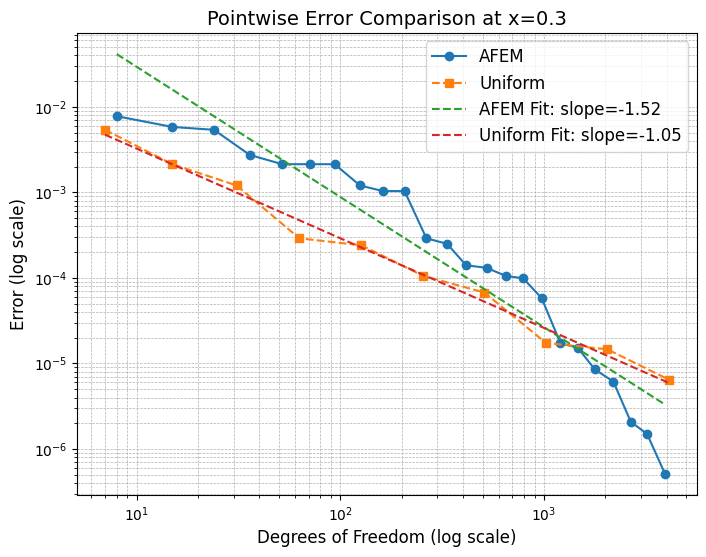

In [ ]:


def gather_pointwise_errors(obs_error_list, obv_points):
    """
    obs_error_list: list of length = number_of_iterations
      each entry is a 1D array of shape (len(obv_points),)
      representing the error at each observation point for that iteration

    obv_points: array-like of observation points (e.g. np.linspace(0,1,9))

    Returns:
      A list 'all_pointwise_errors' of length len(obv_points).
      Each entry is a list of length = number_of_iterations,
      storing the error at that observation point across all iterations.
    """
    num_iterations = len(obs_error_list)
    num_points = len(obv_points)

    # Initialize a list of empty lists, one per observation point
    all_pointwise_errors = [[] for _ in range(num_points)]

    # Loop over iterations
    for k in range(num_iterations):
        err_array = obs_error_list[k]  # shape (num_points,)
        # Append the pointwise errors for this iteration
        for i in range(num_points):
            all_pointwise_errors[i].append(err_array[i])

    return all_pointwise_errors

xi, w = np.polynomial.legendre.leggauss(num_quad_points)
xs = 0.5 * ( (0.4- 0.1)*xi + (0.4 + 0.1) )
observation_nodes = xs
true_obs_values = observations_value_list_at_m[-1]
obs_error_list = []
for obs_values in observations_value_list_at_m:
    print("observation values:", obs_values)
    print("len of observation values :", len(obs_values))
    error_obs = true_obs_values - obs_values
    obs_error_list.append(error_obs)

all_afem = gather_pointwise_errors(obs_error_list, observation_nodes)
uniform_ddof = []
uniform_error = []
observation_at_nodes = []
levels = list(range(3, 15))
error_uniform_list = []
for l in levels:
    uniform_mesh = np.linspace(0.0,1.0, (2**l +1)) # 33 nodes 
    c_sol_uniform, f_vect_uniform = solve_scF_once(uniform_mesh, beta_ref)
    dof_l = len(uniform_mesh) -2 
    uniform_ddof.append(dof_l)
    observations_uniform = fe_solution_at_obs(c_sol_uniform, uniform_mesh, observation_nodes)
    observation_at_nodes.append(observations_uniform)
    error_uniform = observations_uniform - delta_obs 
    error_uniform_list.append(error_uniform)

# Convert list of arrays to 2D array: shape (num_levels, num_observation_points)
error_array = np.vstack(error_uniform_list)  # shape = (12, 9) if levels=range(3,15)

# Create a DataFrame with:
#   rows = each refinement level
#   columns = each observation point
df = pd.DataFrame(
    error_array,
    index=[f"l={lvl}" for lvl in levels],
    columns=[f"x={x:.3f}" for x in observation_nodes]
)

print(df)
    
    # nodal_uniform = assemble_nodal_values(c_sol_uniform)
    # approximation = nodal_uniform.T @ f_vect_uniform
    # error_uniform = true_approx - approximation.item()
    # ddof_u = ((2**l +1) - 2)  # or 2**l - 1
    # uniform_ddof.append(ddof_u)
    # uniform_error.append(error_uniform)

import numpy as np
import matplotlib.pyplot as plt

def plot_afem_vs_uniform(afem_error, ddof_list,
                         uniform_error, ddof_uniform,
                         x_val=0.375):
    """
    Plots AFEM vs. Uniform refinement errors at a single observation point
    on a log-log scale.

    Parameters
    ----------
    afem_error : array-like
        Errors for AFEM at the chosen observation point, for each iteration.
    ddof_list : array-like
        Degrees of freedom corresponding to each AFEM iteration.
    uniform_error : array-like
        Errors for Uniform refinement at the same observation point,
        for each refinement level.
    ddof_uniform : array-like
        Degrees of freedom for each uniform refinement level.
    x_val : float, optional
        The x-coordinate of the observation point, used in the plot title.
    """

    plt.figure(figsize=(8, 6))
    
    # Convert to NumPy arrays if needed (for safety)
    afem_error = np.array(afem_error, dtype=float)
    ddof_list = np.array(ddof_list, dtype=float)
    uniform_error = np.array(uniform_error, dtype=float)
    ddof_uniform = np.array(ddof_uniform, dtype=float)

    # For AFEM
    log_dof_afem = np.log(ddof_list)
    log_afem     = np.log(afem_error)

    sp_afem, interc_afem = np.polyfit(log_dof_afem, log_afem, 1)
    error_fit_afem = np.exp(interc_afem) * (ddof_list ** sp_afem)


    log_dof_uniform = np.log(ddof_uniform)
    log_uniform     = np.log(uniform_error)

    sp_uniform, interc_uniform = np.polyfit(log_dof_uniform, log_uniform, 1)
    error_fit_uniform = np.exp(interc_uniform) * (ddof_uniform ** sp_uniform)


    # Plot AFEM data
    plt.plot(ddof_list, afem_error, 'o-', label='AFEM')

    # Plot Uniform data
    plt.plot(ddof_uniform, uniform_error, 's--', label='Uniform')

    # Set log-log scale
    plt.xscale('log')
    plt.yscale('log')
    plt.loglog(ddof_list, error_fit_afem, '--', label=f'AFEM Fit: slope={sp_afem:.2f}')
    plt.loglog(ddof_uniform, error_fit_uniform, '--', label=f'Uniform Fit: slope={sp_uniform:.2f}' )    
    plt.xlabel('Degrees of Freedom (log scale)', fontsize=12)
    plt.ylabel('Error (log scale)', fontsize=12)
    plt.title(f'Pointwise Error Comparison at x={x_val}', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.show()
afem_error_slice = all_afem[3][0:24]

# If ddof_list also has 30+ entries, slice it the same way
ddof_afem_slice = delta_ddof_list[0:24]

# For uniform data, suppose df has at least 20 rows, so we can do:
uniform_error_slice = abs(df.iloc[0:10, 3])  # the first 20 rows of column index 3
ddof_array = [2**l - 1 for l in levels]
# Similarly, if ddof_uniform has at least 20 entries, slice it:
ddof_uniform_slice = uniform_ddof[0:10]
plot_afem_vs_uniform(afem_error_slice, ddof_afem_slice, uniform_error_slice, ddof_uniform_slice, 0.3)